<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 5:  Web Scraping
### Finding Underpriced RVs on Craigslist

![](https://snag.gy/WrdUMx.jpg)

In this project we will be practicing our web scraping skills.  You can use Scrapy or Python requests in order to complete this project.  It may be helpful to write some prototype code in this notebook to test your assumptions, then move it into a Python file that can be run from the command line.

> In order to run code from the command line, instead of the notebook, you just need to save your code to a file (with a .py extension), and run it using the Python interpreter:<br><br>
> `python my_file.py`

You will be building a process to scrape a single category of search results on Craigslist, that can easily be applied to other categories by changing the search terms.  The main goal is to be able to target and scrape a single page given a set of parameters.

**If you use Scrapy, provide your code in a folder.**

## Import your libraries for scrapy / requests / pandas / numpy / etc
Setup whichever libraries you need. Review past material for reference.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline

In [2]:
import re
import scrapy
import requests
from scrapy.selector import Selector
from scrapy.http import HtmlResponse

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1.  Scrape for the largest US cities (non-exhaustive list)
Search, research, and scrape Wikipedia for a list of the largest US cities.  There are a few sources but find one that is in a nice table.  We don't want all cities, just signifficant cities.  Examine your source.  Look for what can be differentiable.

- Use requests
- Build XPath query(ies)
- Extract to a list
- Clean your list

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population'
response = requests.get(url)
HTML = response.text
HTML[0:500]

u'<!DOCTYPE html>\n<html class="client-nojs" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8"/>\n<title>List of United States cities by population - Wikipedia</title>\n<script>document.documentElement.className = document.documentElement.className.replace( /(^|\\s)client-nojs(\\s|$)/, "$1client-js$2" );</script>\n<script>(window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"List_of_United_States_cities'

In [4]:
top_50 = Selector(text=HTML).xpath('//div[@class="floatnone"]/a/@title').extract()
print top_50[:3]

def parser(uni):
    # RAW unicode: u'1.  New York, New York'
    l = str(uni).split('.  ')
    return l[1].split(', ')

top_50 = map(parser, top_50)

[u'1.  New York, New York', u'2.  Los Angeles, California', u'3.  Chicago, Illinois']


In [5]:
city_df = pd.DataFrame(top_50, columns=['City','State'])

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1.2 Only retain cities with properly formed ASCII

Optionally, filter out any cities with impropper ASCII characters.  A smaller list will be easier to look at.  However you may not need to filter these if you spend more time scraping a more concise city list.  This list should help you narrow down the list of regional Craigslist sites.

In [6]:
# I HAVE DONE

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2.  Write a function to capture current pricing information via Craigslist in one city.
Choose a city from your scraped data, then go to the cooresponding city section on Craigslist, searching for "rv" in the auto section.  Write a method that pulls out the prices.

In [7]:
# https://www.craigslist.org/about/sites#US
# choose New York: https://newyork.craigslist.org/

def get_prices_from_craigslist(keyword, city_url):
    # https://newyork.craigslist.org/search/sss?sort=rel&query=rv
    full_url = city_url + '/search/sss?sort=rel&query=' + keyword
    response = requests.get(full_url)
    html = response.text
    px = Selector(text=html).xpath('//a[@class="i gallery"]/span[@class="price"]/text()').extract()
    px = map(lambda p: float(str(p).replace('$','')), px)
    
    print 'Get %d prices from %s' %(len(px), response.url)
    
    return px
    
px = get_prices_from_craigslist('rv', 'https://newyork.craigslist.org')

px[:10]

Get 74 prices from https://newyork.craigslist.org/search/sss?sort=rel&query=rv


[55.0, 3000.0, 15000.0, 350.0, 19999.0, 310.0, 75.0, 82500.0, 20000.0, 8900.0]

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2.1 Create a mapping of cities to cooresponding regional Craigslist URLs

Major US cities on Craigslist typically have their own cooresponding section (ie: SFBay Area, NYC, Boston, Miami, Seattle, etc).  Later, you will use these to query search results for various metropolitian regions listed on Craigslist.  Between the major metropolitan Craigslist sites, the only thing that will differ is the URL's that correspond to them.

The point of the "mapping":  Create a data structure that allows you to iterate with both the name of the city from Wikipedia, with the cooresponding variable that that will allow you to construct each craigslist URL for each region.

> For San Francsico (the Bay Area metropolitan area), the url for the RV search result is:
> http://sfbay.craigslist.org/search/sss?query=rv
>
> The convention is http://[region].craigslist.org/search/sss?query=rf
> Replacing [region] with the cooresponding city name will allow you to quickly iterate through each regional Craigslist site, and scrape the prices from the search results.  Keep this in mind while you build this "mapping".


In [8]:
# I found this site super useful so I scraped it
# https://sites.google.com/site/clsiteinfo/area-id-sort

response = requests.get('https://sites.google.com/site/clsiteinfo/area-id-sort')
html = response.text
URLs = Selector(text=html).xpath('//td/a[@rel="nofollow"]/text()').extract()

In [9]:
search_url = lambda city_name: 'http://%s.craigslist.org' % city_name.replace(' ','').lower()
city_df['CL_url'] = city_df.City.apply(lambda c: search_url(c) if search_url(c) in URLs else np.nan)

# Manually update the URls for these cities
city_df[city_df.CL_url.isnull()]

,City,State,CL_url
9,San Jose,California,NaN
12,San Francisco,California,NaN
15,Fort Worth,Texas,NaN
21,Washington,District of Columbia,NaN
36,Long Beach,California,NaN
37,Mesa,Arizona,NaN
39,Colorado Springs,Colorado,NaN
40,Virginia Beach,Virginia,NaN
44,Oakland,California,NaN
49,Arlington,Texas,NaN


In [10]:
def fill_url(row):
    if row['CL_url'] != row['CL_url']:
        city_to_url = {'San Jose': 'http://sfbay.craigslist.org',
                       'San Francisco': 'http://sfbay.craigslist.org',
                       'Fort Worth': 'http://dallas.craigslist.org',
                       'Washington': 'http://washingtondc.craigslist.org',
                       'Long Beach': 'http://losangeles.craigslist.org',
                       'Mesa': 'http://phoenix.craigslist.org',
                       'Colorado Springs': 'http://cosprings.craigslist.org',
                       'Virginia Beach': 'http://norfolk.craigslist.org',
                       'Oakland': 'http://sfbay.craigslist.org',
                       'Arlington': 'http://dallas.craigslist.org'}
        return city_to_url[row['City']]
    else:
        return row['CL_url']

city_df['CL_url'] = city_df.apply(fill_url,axis=1)

In [11]:
# Cities like San Francisco, Long Beach & Fort Worth would be dropped due to duplication

city_df.drop_duplicates(subset='CL_url',keep='first',inplace=True)
city_df['Domain'] = city_df['CL_url'].apply(lambda url: re.findall("(?<=//)\w+",url)[0])
city_df.head()

,City,State,CL_url,Domain
0,New York,New York,http://newyork.craigslist.org,newyork
1,Los Angeles,California,http://losangeles.craigslist.org,losangeles
2,Chicago,Illinois,http://chicago.craigslist.org,chicago
3,Houston,Texas,http://houston.craigslist.org,houston
4,Philadelphia,Pennsylvania,http://philadelphia.craigslist.org,philadelphia


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Define a function to caculate mean and median price per city.

Now that you've created a list of cities you want to scrape, adapt your solution for grabbing data in one region site, to grab data for all regional sites that you collected, then calculate the mean and median price of RV results from each city.

> Look at the URLs from a few different regions (ie: portland, phoenix, sfbay), and find what they have in common.  Determine the area in the URL string that needs to change the least, and figure out how to replace only that portion of the URL in order to iterate through each city.

In [12]:
from time import sleep

def get_price_from_links(keyword, links):
    
    price_list = []
    
    for link in links:
        # this functions request from URL
        p = get_prices_from_craigslist(keyword, link)
    
        while not p:
            # Sleep a bit so CL won't ban me
            sleep_amt = np.random.randint(60, 120)
            print 'Sleep %d secs' %sleep_amt
            sleep(sleep_amt)
            
            # this functions request from URL
            p = get_prices_from_craigslist(keyword, link)
        price_list.append(p)
        
    return price_list

In [13]:
# only obtain the prices in the first page

p_list = get_price_from_links('rv', city_df['CL_url'])

Get 74 prices from http://newyork.craigslist.org/search/sss?sort=rel&query=rv
Get 57 prices from http://losangeles.craigslist.org/search/sss?sort=rel&query=rv
Get 69 prices from http://chicago.craigslist.org/search/sss?sort=rel&query=rv
Get 19 prices from http://houston.craigslist.org/search/sss?sort=rel&query=rv
Get 75 prices from http://philadelphia.craigslist.org/search/sss?sort=rel&query=rv
Get 90 prices from http://phoenix.craigslist.org/search/sss?sort=rel&query=rv
Get 15 prices from http://sanantonio.craigslist.org/search/sss?sort=rel&query=rv
Get 70 prices from http://sandiego.craigslist.org/search/sss?sort=rel&query=rv
Get 59 prices from http://dallas.craigslist.org/search/sss?sort=rel&query=rv
Get 76 prices from http://sfbay.craigslist.org/search/sss?sort=rel&query=rv
Get 30 prices from http://austin.craigslist.org/search/sss?sort=rel&query=rv
Get 84 prices from http://jacksonville.craigslist.org/search/sss?sort=rel&query=rv
Get 80 prices from http://indianapolis.craigslist.o

In [14]:
city_df['RV_Price_1p'] = p_list
city_df['Mean_Price'] = city_df['RV_Price_1p'].apply(np.mean)
city_df['Median_Price'] = city_df['RV_Price_1p'].apply(np.median)

city_df[['City', 'Mean_Price', 'Median_Price']].head(10)

,City,Mean_Price,Median_Price
0,New York,9443.445946,3022.5
1,Los Angeles,28912.789474,26400.0
2,Chicago,18270.057971,8500.0
3,Houston,24422.578947,26997.0
4,Philadelphia,23268.480000,3500.0
5,Phoenix,31339.833333,28828.5
6,San Antonio,23812.066667,25995.0
7,San Diego,5718.800000,342.5
8,Dallas,29310.542373,23459.0
9,San Jose,28000.394737,26400.0


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Run your scraping process, and save your results to a CSV file.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. Do an analysis of the RV market.

Go head we'll wait.  Anything notable about the data?

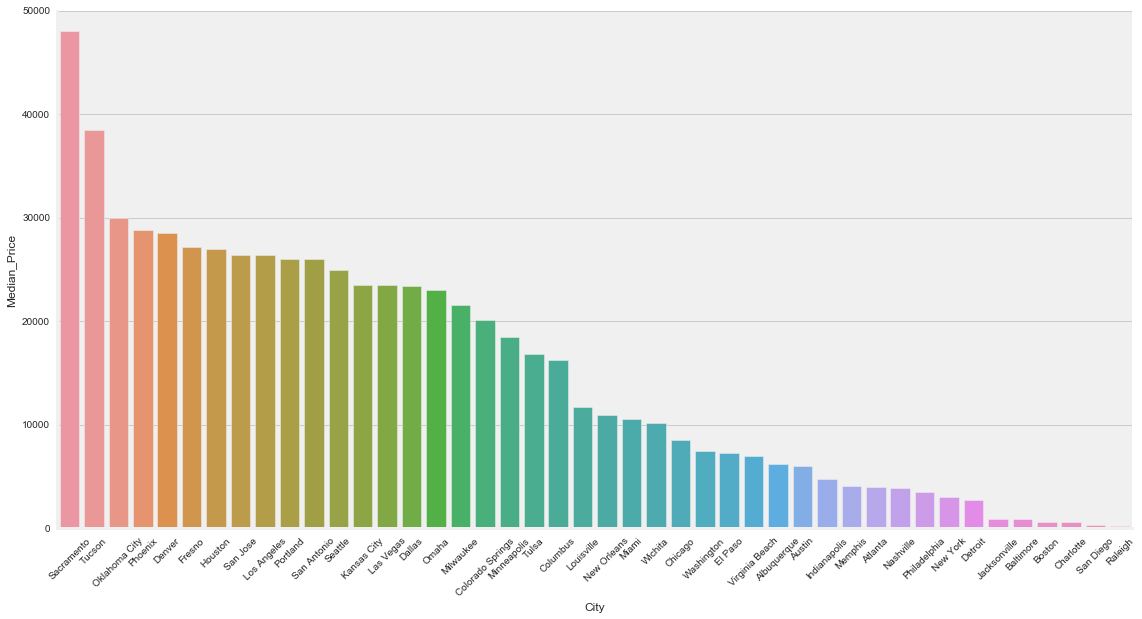

In [15]:
sns.factorplot('City','Median_Price',data=city_df.sort_values(by='Median_Price',ascending=False),
               kind='bar',size=8, aspect=2).set_xticklabels(rotation=45)

In [16]:
# I think median is a better statisic over mean in this case since it's less sensitive to outliers.
# Though the median price differs across city,
# the number of sample price is quite low and some sample price is not actual 'RV' but the 'accessory' of RV,
# so the prices are not representative enough

# -> we scrapy all data from craigslist and calculate the median again

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 5.1 Does it makes sense to buy RVs in one region and sell them in another?

Assuming the cost of shipping or driving from one regional market to another.

In [17]:
# answer this question later

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 5.2 Can you pull out the "make" from the markup and include that in your analyis?
How reliable is this data and does it make sense?

In [18]:
# answer this question later

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 5.3 Are there any other variables you could pull out of the markup to help describe your dataset?

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 6. Move your project into scrapy (if you haven't used Scrapy yet)

>Start a project by using the command `scrapy startproject [projectname]`
> - Update your settings.py (review our past example)
> - Update your items.py
> - Create a spiders file in your `[project_name]/[project_name]/spiders` directory

You can update your spider class with the complete list of craigslist "start urls" to effectively scrape all of the regions.  Start with one to test.

Updating your parse method with the method you chose should require minimal changes.  It will require you to update your parse method to use the response parameter, and an item model (defined in items.py).

In [19]:
# output for my spider

short_urls = city_df.CL_url.tolist()
short_urls

['http://newyork.craigslist.org',
 'http://losangeles.craigslist.org',
 'http://chicago.craigslist.org',
 'http://houston.craigslist.org',
 'http://philadelphia.craigslist.org',
 'http://phoenix.craigslist.org',
 'http://sanantonio.craigslist.org',
 'http://sandiego.craigslist.org',
 'http://dallas.craigslist.org',
 'http://sfbay.craigslist.org',
 'http://austin.craigslist.org',
 'http://jacksonville.craigslist.org',
 'http://indianapolis.craigslist.org',
 'http://columbus.craigslist.org',
 'http://charlotte.craigslist.org',
 'http://seattle.craigslist.org',
 'http://denver.craigslist.org',
 'http://elpaso.craigslist.org',
 'http://detroit.craigslist.org',
 'http://washingtondc.craigslist.org',
 'http://boston.craigslist.org',
 'http://memphis.craigslist.org',
 'http://nashville.craigslist.org',
 'http://portland.craigslist.org',
 'http://oklahomacity.craigslist.org',
 'http://lasvegas.craigslist.org',
 'http://baltimore.craigslist.org',
 'http://louisville.craigslist.org',
 'http://mi

In [20]:
all_rv = pd.read_json('craigslist/craigslist/rv_price.json')
print all_rv.shape
all_rv['price'] = all_rv['price'].apply(lambda s: int(re.findall('[0-9]+', s)[0]))
all_rv.head()

(49403, 2)


,domain,price
0,losangeles,9700
1,losangeles,9700
2,losangeles,100
3,losangeles,19995
4,losangeles,48050


In [21]:
all_rv.describe()

,price
count,4.940300e+04
mean,2.670788e+04
std,4.526073e+05
min,1.000000e+00
25%,2.950000e+03
50%,1.548800e+04
75%,3.100000e+04
max,1.002003e+08


In [22]:
# drop outliers
all_rv = all_rv[(all_rv.price < 1000000) | (all_rv.price > 100)]
all_rv.shape

(49403, 2)

In [23]:
CL_all_rv_px = all_rv.groupby('domain')['price'].agg(
    {'count_all_rv': 'count', 'mean_all_rv': np.mean, 'median_all_rv': np.median}).reset_index()
city_df = city_df.merge(CL_all_rv_px, left_on='Domain', right_on='domain')
city_df.head()

,City,State,CL_url,Domain,RV_Price_1p,Mean_Price,Median_Price,domain,count_all_rv,median_all_rv,mean_all_rv
0,New York,New York,http://newyork.craigslist.org,newyork,"[55.0, 3000.0, 15000.0, 350.0, 19999.0, 310.0,...",9443.445946,3022.5,newyork,173,3000.0,9113.138728
1,Los Angeles,California,http://losangeles.craigslist.org,losangeles,"[19799.0, 3699.0, 19995.0, 48050.0, 44995.0, 3...",28912.789474,26400.0,losangeles,1948,1000.0,12988.983060
2,Chicago,Illinois,http://chicago.craigslist.org,chicago,"[68996.0, 32996.0, 19996.0, 20996.0, 32896.0, ...",18270.057971,8500.0,chicago,628,7150.0,16964.590764
3,Houston,Texas,http://houston.craigslist.org,houston,"[5800.0, 5500.0, 49995.0, 37900.0, 21987.0, 50...",24422.578947,26997.0,houston,1235,20365.0,27152.365992
4,Philadelphia,Pennsylvania,http://philadelphia.craigslist.org,philadelphia,"[39999.0, 10999.0, 15500.0, 303900.0, 25000.0,...",23268.480000,3500.0,philadelphia,813,8800.0,24803.678967


Mean Price: 26707.8788535
Median Price: 15488.0


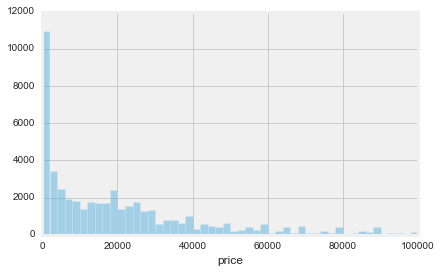

In [24]:
print 'Mean Price:',all_rv.price.mean()
print 'Median Price:',all_rv.price.median()

sns.distplot(all_rv[all_rv.price < 100000]['price'],bins=50,kde=False)

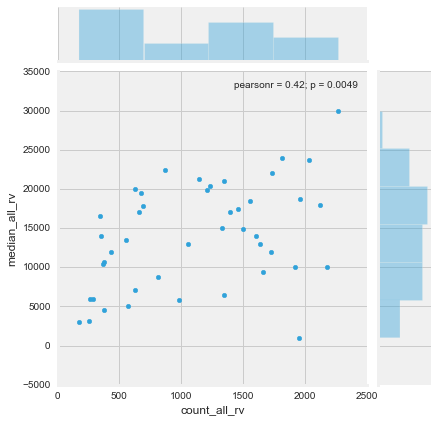

In [25]:
sns.jointplot('count_all_rv', 'median_all_rv', city_df)

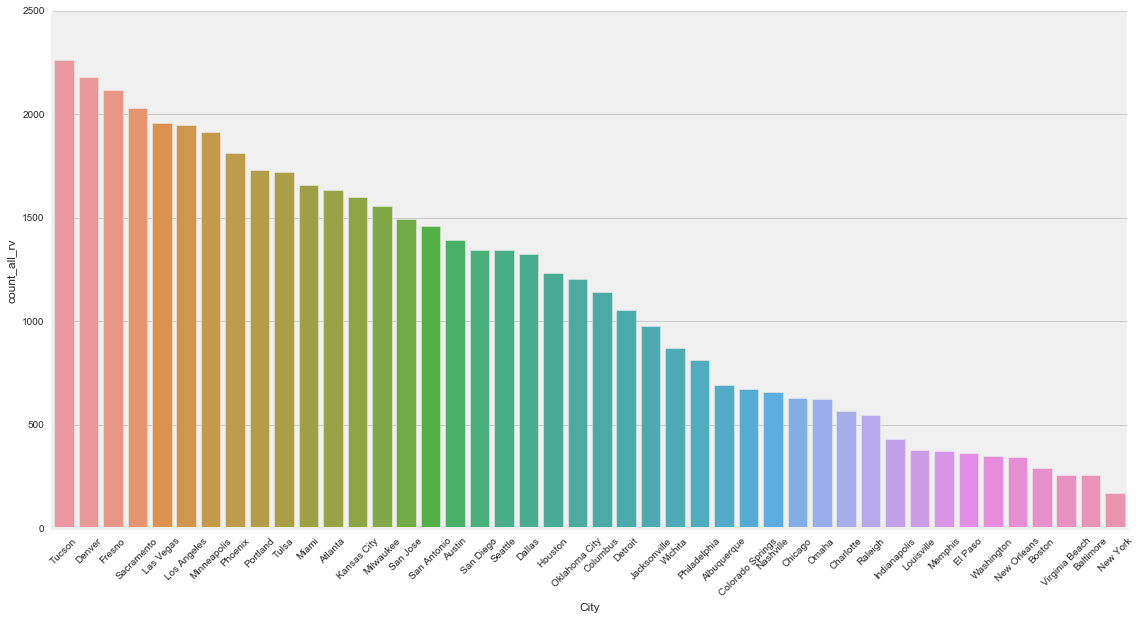

In [26]:
sns.factorplot('City','count_all_rv',data=city_df.sort_values(by='count_all_rv',ascending=False),
               kind='bar',size=8, aspect=2).set_xticklabels(rotation=45)

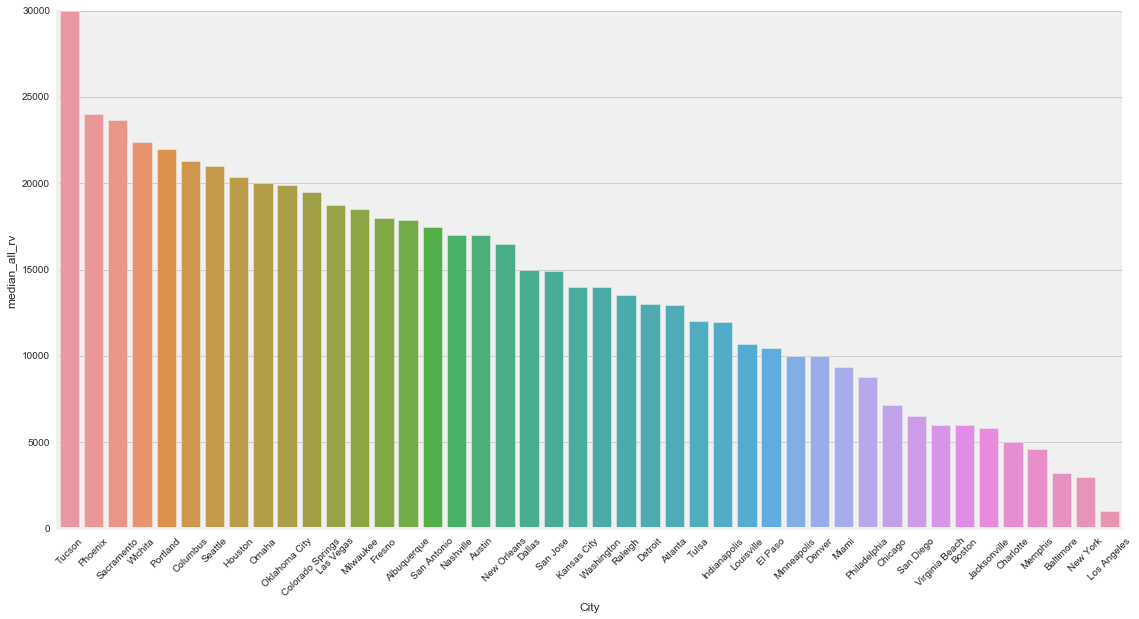

In [27]:
sns.factorplot('City','median_all_rv',data=city_df.sort_values(by='median_all_rv',ascending=False),
               kind='bar',size=8, aspect=2).set_xticklabels(rotation=45)

In [28]:
# Does it makes sense to buy RVs in one region and sell them in another?
# OK. Let's compare the prices among 3 cities in California:
# Los Angeles, SF bay (San Jose) and Sacramento

city_df.ix[[1, 9, 32], ['City', 'Domain', 'median_all_rv', 'mean_all_rv']]

,City,Domain,median_all_rv,mean_all_rv
1,Los Angeles,losangeles,1000.0,12988.983060
9,San Jose,sfbay,14900.0,25312.783802
32,Sacramento,sacramento,23695.0,31715.925160


Difference in median price (SAC-LA): 22695.0
Difference in median price (SAC-SF): 8795.0
Difference in median price (SF-LA) : 13900.0


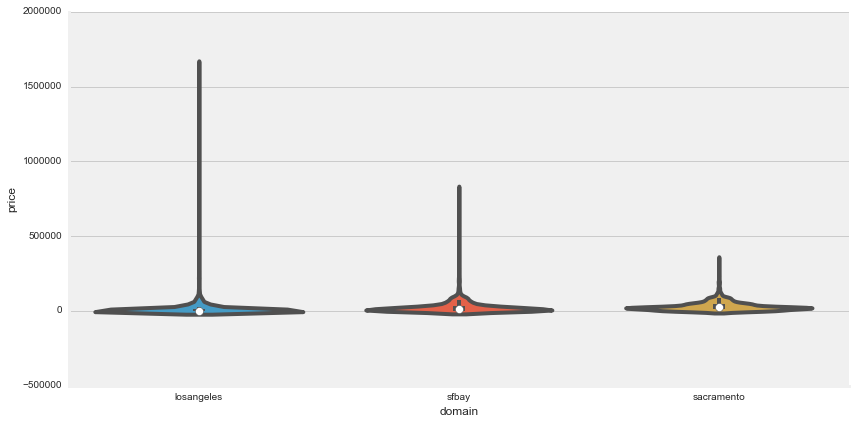

In [29]:
print 'Difference in median price (SAC-LA):', city_df.ix[32, 'median_all_rv'] - city_df.ix[1, 'median_all_rv']
print 'Difference in median price (SAC-SF):', city_df.ix[32, 'median_all_rv'] - city_df.ix[9, 'median_all_rv']
print 'Difference in median price (SF-LA) :', city_df.ix[9, 'median_all_rv'] - city_df.ix[1, 'median_all_rv']

sns.factorplot(x='domain', y='price',
               data=all_rv[(all_rv.domain == 'losangeles')|(all_rv.domain == 'sfbay')|(all_rv.domain == 'sacramento')],
               kind='violin',size=6, aspect=2)

In [30]:
# at the first glance, it is reasonable to buy RV in Los Angeles and sell it in Sacramento (or SF Bay Area),
# but we still need to take cost of carry and the quality of goods into consideration

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 7.  Chose another area of Craigslist to scrape.

**Choose an area having more than a single page of results, then scrape multiple regions, multiple pages of search results and or details pages.**

This is the true exercise of being able to understand how to succesffuly plan, develop, and employ a broader scraping strategy.  Even though this seems like a challenging task, a few tweeks of your current code can make this very managable if you've pieced together all the touch points.  If you are still confused as to some of the milestones within this process, this is an excellent opportunity to round out your understanding, or help you build a list of questions to fill in your gaps.

_Use Scrapy!  Provide your code in this project directory when you submit this project._

In [31]:
all_bike = pd.read_json('craigslist/craigslist/bike_price.json')
print all_bike.shape
all_bike['price'] = all_bike['price'].apply(lambda s: int(re.findall('[0-9]+', s)[0]))
all_bike.head()

(90193, 2)


,domain,price
0,chicago,1
1,chicago,200
2,chicago,200
3,chicago,250
4,chicago,100


In [32]:
all_bike = all_bike[(all_bike.price < 800000) | (all_bike.price > 100)]
all_bike.shape

CL_all_bike_px = all_bike.groupby('domain')['price'].agg(
    {'count_all_bike': 'count', 'mean_all_bike': np.mean, 'median_all_bike': np.median}).reset_index()
city_df = city_df.merge(CL_all_bike_px, left_on='Domain', right_on='domain')

In [33]:
all_bike.describe()

,price
count,9.019300e+04
mean,4.043549e+04
std,8.062122e+06
min,1.000000e+00
25%,7.500000e+01
50%,3.000000e+02
75%,2.395000e+03
max,2.147484e+09


Mean Price: 40435.4902598
Median Price: 300.0


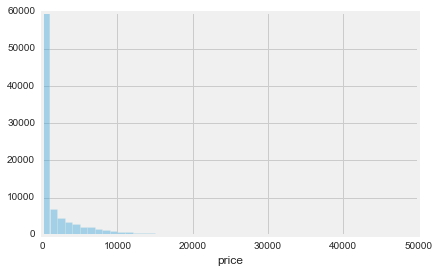

In [34]:
print 'Mean Price:',all_bike.price.mean()
print 'Median Price:',all_bike.price.median()

sns.distplot(all_bike[all_bike.price < 50000]['price'],bins=50,kde=False)

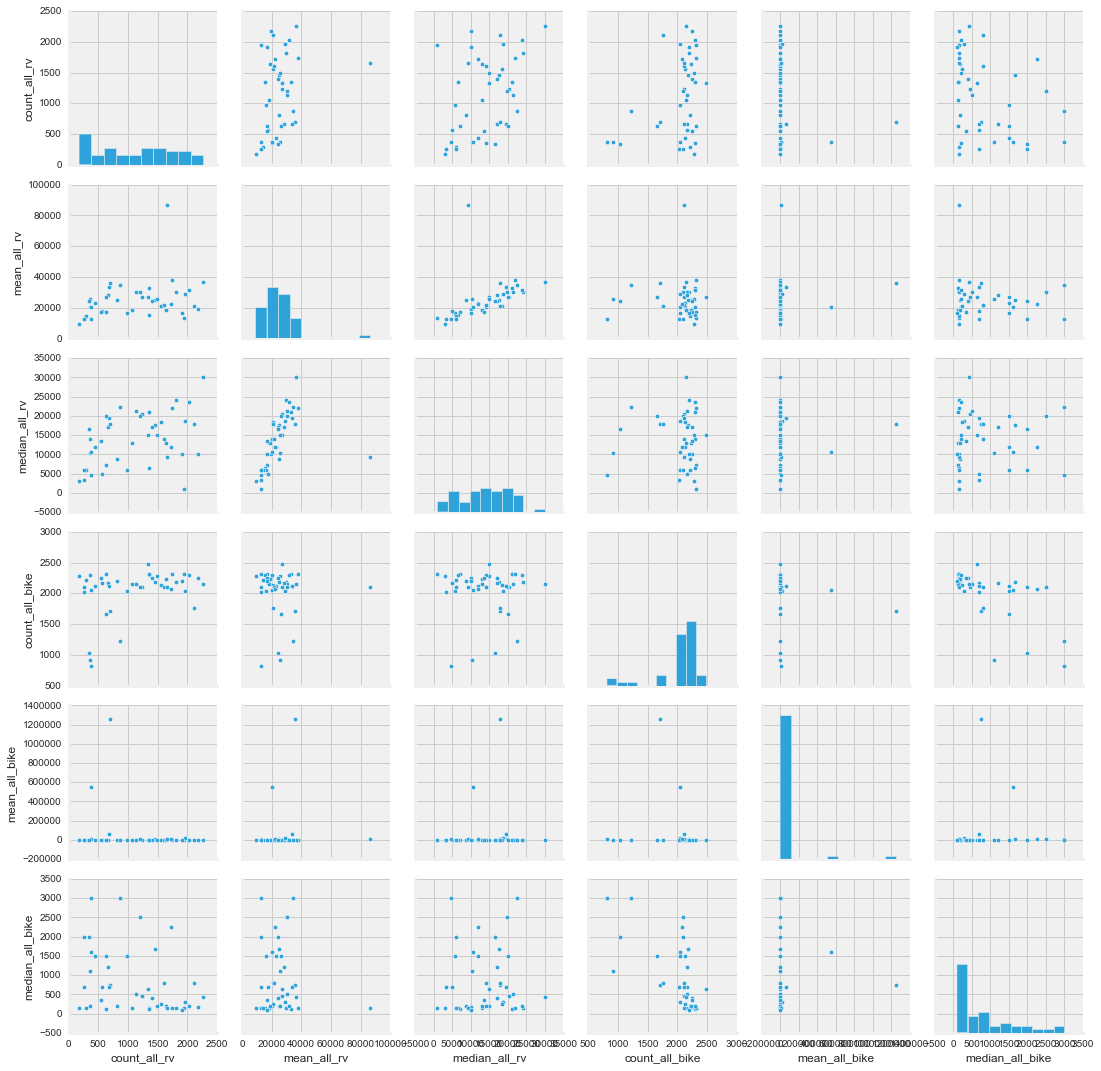

In [35]:
sns.pairplot(city_df[['count_all_rv', 'mean_all_rv', 'median_all_rv','count_all_bike', 'mean_all_bike', 'median_all_bike']])

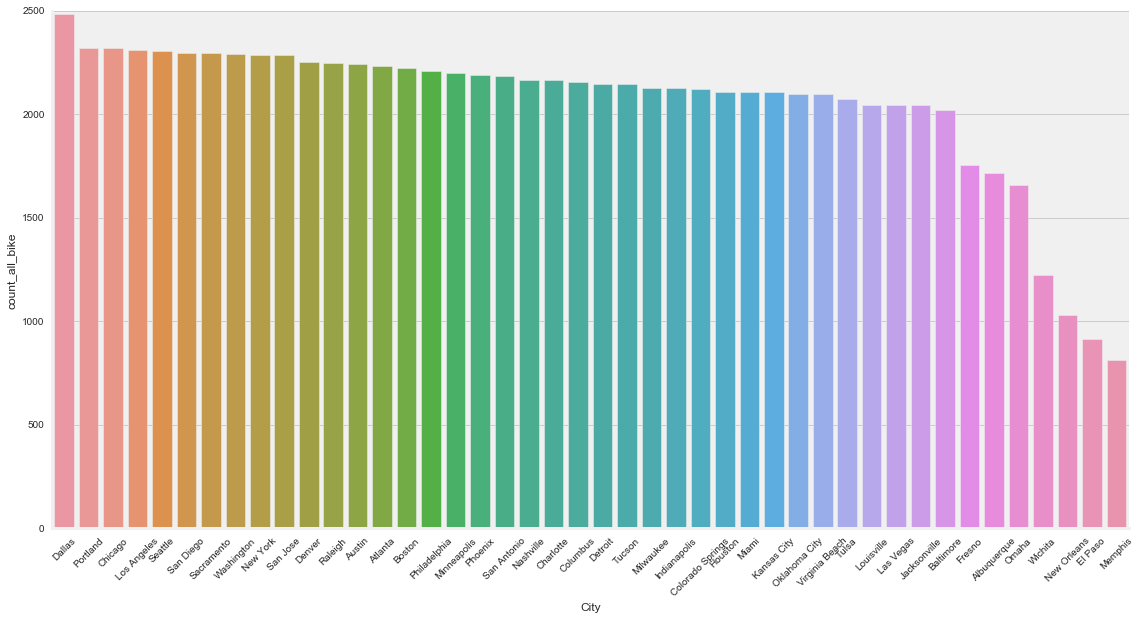

In [36]:
sns.factorplot('City','count_all_bike',data=city_df.sort_values(by='count_all_bike',ascending=False),
               kind='bar',size=8, aspect=2).set_xticklabels(rotation=45)

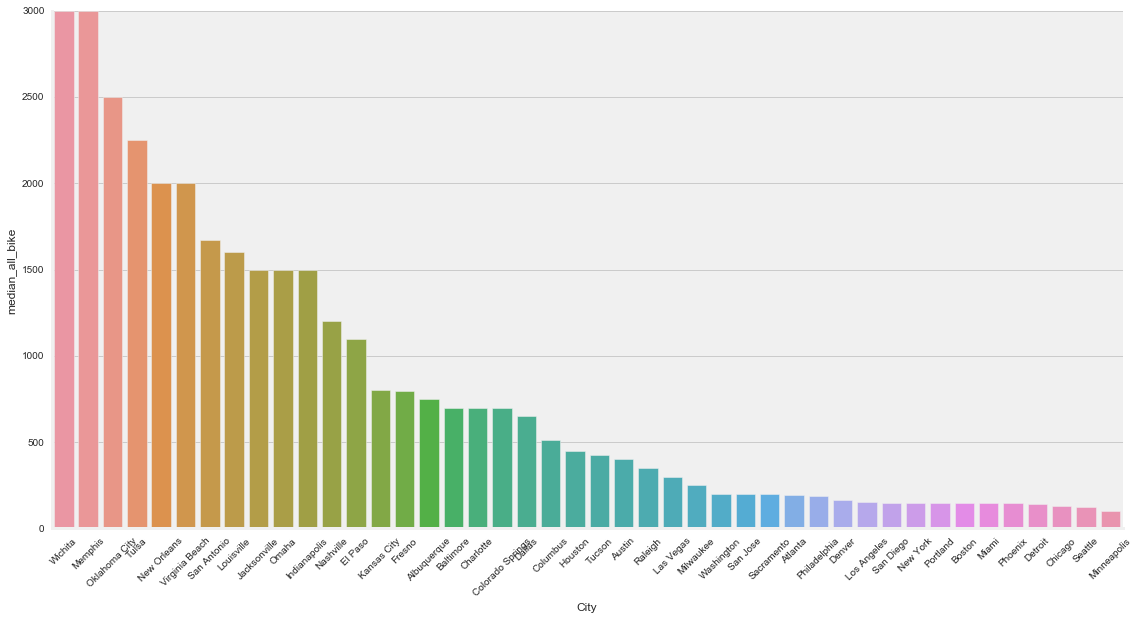

In [37]:
sns.factorplot('City','median_all_bike',data=city_df.sort_values(by='median_all_bike',ascending=False),
               kind='bar',size=8, aspect=2).set_xticklabels(rotation=45)

In [38]:
city_df.ix[[8, 24], ['City', 'Domain', 'median_all_bike', 'mean_all_bike', 'count_all_bike']]

,City,Domain,median_all_bike,mean_all_bike,count_all_bike
8,Dallas,dallas,649.0,821.541902,2482
24,Oklahoma City,oklahomacity,2500.0,4610.728531,2096


Difference in median price: 1851.0


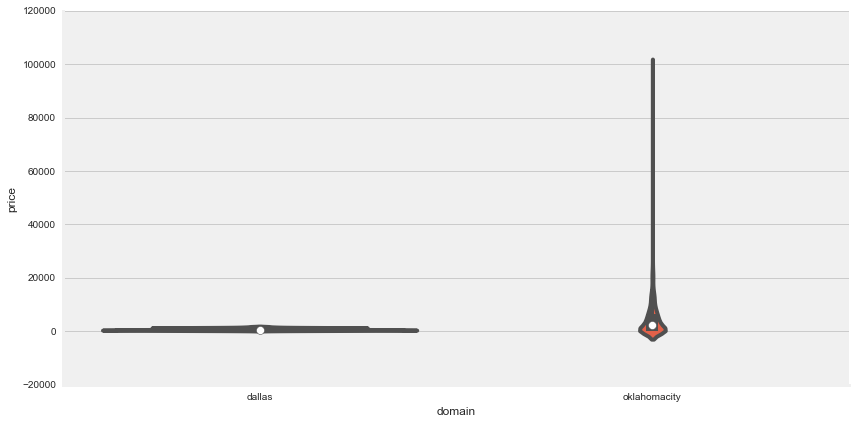

In [39]:
# cool, buy bikes in Dallas and sell them in Oklahomeca city is a good idea!

print 'Difference in median price:', city_df.ix[24, 'median_all_bike'] - city_df.ix[8, 'median_all_bike']

sns.factorplot(x='domain', y='price',
               data=all_bike[(all_bike.domain == 'dallas') | (all_bike.domain == 'oklahomacity')],
               kind='violin',size=6, aspect=2)

## Optional: Interview Questions

---- 

### SQL Practice

1)
We have a deliveries table with 3000 rows

`SELECT * FROM deliveries; 
-- 3000 rows in set (0.05 sec) `

15 of those orders are from a customer with the customer_id_number=32

`SELECT * FROM deliveries WHERE customer_id_number = 32;
-- 15 rows in set (0.10 sec)`

Yet, when we SELECT the number of orders that are not from customer_id_number = 32, we only get 2960 results:

`SELECT * FROM deliveries WHERE customer_id_number <> 32;
-- 2960 rows in set (0.11 sec)`

**Question: What’s wrong? And why might this be the case? Modify your code to fix this. **

2) Construct the following tables:

`mysql> SELECT * FROM Employee;
+--------+----------+--------+
| emp_id | emp_name | salary |
+--------+----------+--------+
| 1      | James    |   2000 |
| 2      | Jack     |   4000 |
| 3      | Henry    |   6000 |
| 4      | Tom      |   8000 |
+--------+----------+--------+
4 rows IN SET (0.00 sec)`


`mysql> SELECT * FROM Department;
+---------+-----------+
| dept_id | dept_name |
+---------+-----------+
| 101     | Sales     |
| 102     | Marketing |
| 103     | Finance   |
| 104     | Accounting   |
+---------+-----------+
3 rows IN SET (0.00 sec)`


`mysql> SELECT * FROM Register;
+--------+---------+
| emp_id | dept_id |
+--------+---------+
|      1 |     101 |
|      2 |     102 |
|      3 |     103 |
|      4 |     102 |
+--------+---------+
4 rows IN SET (0.00 sec)`

** Questions: ** 
- Which employees belong to which department? Show this using one line of code (hint: more than one join) 
- What is the total marketing salary? 
- Using a join, can you show that there are no employees in accounting? 



3) Given an Employee table which has 3 fields – Id (Primary key), Salary and Manager Id, where manager id is the id of the employee that manages the current employee, find all employees that make more than their manager in terms of salary. Create the table and write the code that finds this


--- 
### Predictive Modeling

- What are some differences you would expect in a regression model that minimizes squared error, versus a model that minimizes absolute error? In which cases would each error  metric be appropriate?

- What error metric would you use to evaluate how good a binary classifier is? What if the classes are imbalanced?  What if there are more than 2 groups?

- What are various ways to predict a binary response variable? Can you compare two of them and tell me when one would be more appropriate? What’s the difference logistic regression and SVMs? 

- What is the difference between the loss functions used by SVMs and Logistic Regression? 

- What is R-squared? What are some other metrics that could be better than R-squared and why?

- You run your regression on different subsets of your data, and find that in each subset, the beta value for a certain variable varies wildly. What could be the issue here?


--- 
### Coding Questions 

- Given a sorted array and a number x, find a pair in array whose sum is closest to x. What is the time complexity of your algorithm? 
    
    `Examples:`
        Input: arr[] = {10, 22, 28, 29, 30, 40}, x = 54
        Output: 22 and 30

        Input: arr[] = {1, 3, 4, 7, 10}, x = 15
        Output: 4 and 10
        
- Check out this video on Linear Time Algorithm for finding the median: https://www.youtube.com/watch?v=_xntajCBLoE. Implement your version of this algorithm in Python. 

- Search in an almost sorted array: Given an array which is sorted, but after sorting some elements are moved to either of the adjacent positions, i.e., arr[i] may be present at arr[i+1] or arr[i-1]. Write an efficient function to search an element in this array. Basically the element arr[i] can only be swapped with either arr[i+1] or arr[i-1]. For example consider the array {2, 3, 10, 4, 40}, 4 is moved to next position and 10 is moved to previous position. [Hint: You can do this O(log n) time complexity]

    `Examples: `
        Input: arr[] =  {10, 3, 40, 20, 50, 80, 70}, key = 40
        Output: 2 
        Output is index of 40 in given array

        Input: arr[] =  {10, 3, 40, 20, 50, 80, 70}, key = 90
        Output: -1
        -1 is returned to indicate element is not present

In [40]:
def find_pair_in_arr(arr, x):
    l = 0
    r = len(arr) - 1
    diff = float('inf')
    
    while r > l:
        temp_sum = arr[l] + arr[r]
        temp_diff = abs(x - temp_sum)
        
        if temp_diff < diff:
            l_index = l
            r_index = r
            diff = temp_diff
        
        if temp_sum < x:
            l += 1
        elif temp_sum > x:
            r -= 1
        else:
            break
    
    return arr[l_index], arr[r_index]

In [41]:
arr = sorted(np.random.randint(0, 100, 10))
x = np.random.randint(0, 200)
print arr, x
find_pair_in_arr(arr, x)

[4, 5, 8, 40, 62, 65, 73, 77, 90, 99] 178


(77, 99)

In [42]:
def select_ith_in_arr(arr, i):
    print '============'
    print i, arr
    
    n = len(arr)
    if n == 0:
        print 'empty array'
        return arr
    elif i > n:
        print 'out of range'
        return None
    elif n == 1:
        print 'ONLY ONE'
        return arr[0]
    elif n == 2:
        print 'PICK'
        return (arr[0] if i == 1 else arr[1])
    else:
        top = arr[:n / 3 + 1]
        mid = arr[n / 3 + 1:2 * n / 3 + 1]
        bot = arr[2 * n / 3 + 1:]
        
        for j in range(len(bot)):
            if mid[j] < top[j]:
                top[j], mid[j] = (mid[j], top[j])
            
            if bot[j] < top [j]:
                top[j], mid[j], bot[j] = (bot[j], top[j], mid[j])
            elif bot[j] < mid[j]:
                mid[j], bot[j] = (bot[j], mid[j])                    
        
        if len(top) == len(mid) and top[-1] > mid[-1]:
            top[-1], mid[-1] = (mid[-1], top[-1])
        
        m = np.median(mid)
        #m = find_median(mid)
        l = filter(lambda x: x < m, arr)
        r = filter(lambda x: x > m, arr)
                
        k = len(l)
        if k == i - 1:
            print 'no effort'
            return m
        elif k > i - 1:
            return select_ith_in_arr(l, i)
        else:
            return select_ith_in_arr(r, i - k)
             
'''
x ← Partition(N, a1, a2, ..., aN)
k ← rank(x)

if (i == k)
    return x

else if (i < k)
    b[] ← all items of a[] less than x
    return Select(ith, k-1, b1, b2, ..., bk-1)

else if (i > k)
    c[] ← all items of a[] greater than x
    return Select((i-k)th, N-k, c1, c2, ..., cN-k)
'''
            
def find_median(arr):
    n = len(arr)
    
    if n % 2:
        return select_ith_in_arr(arr, n / 2)
    else:
        return 0.5 * (select_ith_in_arr(arr, n / 2) + select_ith_in_arr(arr, n / 2 - 1))

In [43]:
pool = range(100)
arr = np.random.choice(pool,6, replace=False)
print np.median(arr)
print sorted(arr)
select_ith_in_arr(arr, 2)

63.0
[3, 32, 43, 83, 85, 97]
2 [43 85 97 32 83  3]
2 [3, 32, 43]
2 [3, 32]
PICK


32

In [44]:
def gen_almost_sorted_arr(n, lower=0, upper=100):

    arr = sorted(np.random.randint(lower, upper, n))
    
    cond = True
    while cond:
        flip = np.random.randint(0, len(arr) - 1)
        cond = arr[flip] == arr[flip + 1]
    
    temp = arr[flip]
    arr[flip] = arr[flip + 1]
    arr[flip + 1] = temp
    
    return arr

In [45]:
gen_almost_sorted_arr(10)

[12, 25, 24, 29, 39, 40, 44, 64, 71, 93]

In [46]:
def search_in_almost_sorted_arr(arr, key):
    l = 0
    r = len(arr) - 1
    
    while l < r:
    
        if arr[l] == key:
            return l
        else:
            l += 1
        
        if arr[r] == key:
            return r
        else:
            r -= 1
    
        m = (l + r) / 2

        # [m-1] > [m] < [m+1]: flipped with left element
        if arr[m - 1] > arr[m]:
            #m = m - 1
            
            if arr[m] == key:
                return m
            elif arr[m - 1] == key:
                return m - 1
            elif arr[m - 1] < key:
                l = m
            elif key < arr[m]:
                r = m - 1
            else:
                break
            
        # [m-1] < [m] > [m+1]
        elif arr[m] > arr[m + 1]:
            #m = m + 1
            
            if arr[m] == key:
                return m
            elif arr[m + 1] == key:
                return m + 1
            elif arr[m] < key:
                l = m
            elif key < arr[m + 1]:
                r = m + 1
            else:
                break
        
        # [m-1] < [m] < [m+1]: not flipped
        else:
            #pass
            if arr[m] == key:
                return m
            elif arr[m] < key:
                l = m
            else:
                r = m
    
    return -1

In [47]:
arr = gen_almost_sorted_arr(15)
print 'arr =', arr
x = np.random.choice(arr, 1)[0]
print 'x =', x
search_in_almost_sorted_arr(arr, x)

arr = [10, 14, 16, 15, 26, 30, 33, 43, 45, 48, 59, 65, 65, 87, 91]
x = 33


6

In [48]:
arr = gen_almost_sorted_arr(15)
print 'arr =', arr
x = np.random.choice(arr, 1)[0] + 0.5
print 'x =', x
search_in_almost_sorted_arr(arr, x)

arr = [7, 18, 13, 31, 32, 39, 39, 45, 47, 50, 50, 50, 55, 56, 88]
x = 88.5


-1